In [1]:
from typing import Optional, Callable, Dict, Sequence

from dataclasses import dataclass, field
from tqdm import trange
import time

from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.amp import autocast
import torch.backends.xnnpack
from torch.profiler import profile, schedule, ProfilerActivity

import triton
import triton.language as tl

### Dummy profiling tool

This will be our main utility for analyzing performance on the GPU.

Pay attention to the scheduler variable in the config. It is very important to make several idle runs before the active phase of measurement to warm up GPU caches

We will focus on the last line "Self CUDA time total: ...", but in general we can analyze specific operations in the table as well

In [2]:
@dataclass
class ProfilerConfig:
    scheduler: Optional[Callable[[int], int]] = field(default=None, metadata={"omegaconf_ignore": True})
    num_steps: int = field(init=False)
    amp: bool = False

    def __post_init__(self):
        if self.scheduler is None:
            self.scheduler = {"skip_first": 2, "wait": 2, "warmup": 5, "active": 3, "repeat": 0}

        self.num_steps = sum([v for k, v in self.scheduler.items() if k != "repeat"])
        self.scheduler = schedule(**self.scheduler)

@torch.inference_mode()
def profile_model(model: nn.Module, input: Dict[str, torch.Tensor], config: ProfilerConfig):
    training_state = model.training
    model.eval()

    with autocast(dtype=torch.float16, device_type="cuda", enabled=config.amp), profile(
        activities=[ProfilerActivity.CUDA ],
        schedule=config.scheduler
    ) as p:
        for _ in range(config.num_steps):
            _ = model(**input)
            p.step()

    model.train(training_state)
    return p

In [3]:
m = nn.Linear(100, 10000).cuda()

p = profile_model(m, {'input': torch.randn(1024, 100).cuda()}, ProfilerConfig(amp=False))
print(p.key_averages())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
cudaOccupancyMaxActiveBlocksPerMultiprocessorWithFla...         5.88%       3.000us         5.88%       3.000us       1.000us       0.000us         0.00%       0.000us       0.000us             3  
                                   cudaFuncSetAttribute         1.96%       1.000us         1.96%       1.000us       0.333us       0.000us         0.00%       0.000us       0.000us             3  
         

[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
[W kineto_shim.cpp:372] Profiler is not initialized: skipping step() invocation
STAGE:2024-03-07 17:15:57 1977:1977 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 17:15:57 1977:1977 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 17:15:57 1977:1977 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


# Fusing

Assume we have HUGE transformer based model

## Projections Fusing

This technique aims to reduce the number of operations. Instead of 3 matrix multiplications (projections on q, k and v) 
we will have one big one, due to which we will reduce the number of calls and memory moves to GPU registers.

The main work will take place in the `fuse_qkv` function, which should be called once before using the layer.

In [5]:
class DummySelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embed size needs to be divisible by heads"

        # Linear layers to generate Query, Key, and Value matrices
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

        self.fused_qkv_projection = None

    def fuse_qkv(self):
        @torch.no_grad()
        def fuse_projections(*projections: Sequence[nn.Linear]) -> nn.Linear:
            concatenated_weights = torch.cat([p.weight.data for p in projections])
            device = concatenated_weights.device
            dtype = concatenated_weights.dtype
            in_features = concatenated_weights.shape[1]
            out_features = concatenated_weights.shape[0]
            projection = nn.Linear(in_features, out_features, bias=False, device=device, dtype=dtype)
            projection.weight.copy_(concatenated_weights)
            return projection
        
        self.fused_qkv_projection = fuse_projections(self.queries, self.keys, self.values)
        del self.queries, self.keys, self.values

    def forward(self, input: torch.Tensor, kv_cache=None) -> torch.Tensor:
        batch_size = input.shape[0]
        input_len = input.shape[1]

        # Split the embedding into self.heads pieces
        input = input.reshape(batch_size, input_len, self.heads, self.head_dim)

        if self.fused_qkv_projection is None:
            q = self.queries(input)
            k = self.keys(input)
            v = self.values(input)

        else:
            q, k, v = self.fused_qkv_projection(input).chunk(chunks=3, dim=-1)

        # Scaled Dot-Product Attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [q, k])
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, v]).reshape(batch_size, input_len, self.heads*self.head_dim)
        return self.fc_out(out)


In [9]:
sa = DummySelfAttention(1024, 8).cuda()
sa_input = torch.randn(32, 128, 1024).cuda()

p = profile_model(sa, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
cudaOccupancyMaxActiveBlocksPerMultiprocessorWithFla...         4.39%      14.000us         4.39%      14.000us       0.778us       0.000us         0.00%       0.000us       0.000us            18  
                                   cudaFuncSetAttribute         0.63%       2.000us         0.63%       2.000us       0.111us       0.000us         0.00%       0.000us       0.000us            18  
         

STAGE:2024-03-07 16:41:15 738907:738907 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 16:41:15 738907:738907 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 16:41:15 738907:738907 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [15]:
sa_fused = DummySelfAttention(1024, 8).cuda()
sa_fused.load_state_dict(sa.state_dict())
sa_fused.fuse_qkv()

p = profile_model(sa_fused, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
cudaOccupancyMaxActiveBlocksPerMultiprocessorWithFla...         6.06%      34.000us         6.06%      34.000us       2.833us       0.000us         0.00%       0.000us       0.000us            12  
                                   cudaFuncSetAttribute         3.57%      20.000us         3.57%      20.000us       1.667us       0.000us         0.00%       0.000us       0.000us            12  
         

STAGE:2024-03-07 16:44:03 738907:738907 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 16:44:03 738907:738907 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 16:44:03 738907:738907 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [13]:
torch.testing.assert_close(sa(sa_input), sa_fused(sa_input))

As we can see the result of work with and without fusing is identical, but at the same time we see a 7-10% increase in timing

### Large scale

For larger nets, the absolute value of acceleration will be larger

In [21]:
sa_large = nn.Sequential(*[DummySelfAttention(1024, 8)] * 10).cuda()

p = profile_model(sa_large, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::elementwise_kernel<128, 2, at::nati...         0.00%       0.000us         0.00%       0.000us       0.000us       5.480ms        29.51%       5.480ms      33.620us           163  
void cutlass::Kernel<cutlass_80_tensorop_s1688gemm_1...         0.00%       0.000us         0.00%       0.000us       0.000us       3.344ms        18.00%       3.344ms      40.780us            82  
void at::

STAGE:2024-03-07 16:50:25 738907:738907 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 16:50:25 738907:738907 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 16:50:25 738907:738907 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [22]:
sa_fused_large = nn.Sequential(*[DummySelfAttention(1024, 8)] * 10).cuda()
for m in sa_fused_large.modules():
    if isinstance(m, DummySelfAttention):
        m.fuse_qkv()

p = profile_model(sa_fused_large, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     610.000us         3.59%     610.000us      14.524us            42  
void (anonymous namespace)::softmax_warp_forward<flo...         0.00%       0.000us         0.00%       0.000us       0.000us     743.000us         4.38%     743.000us      17.690us            42  
void at::

STAGE:2024-03-07 16:50:27 738907:738907 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 16:50:27 738907:738907 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 16:50:27 738907:738907 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


## Element-wise Fusing

The following optimization is similar to the previous one. In modern DL there are many activations, which is a composition of simple operations, e.g. elementwise multiplication/addition, sigmoid/tangent.

In case we naively implement such activations, each elementwise operation is performed by a separate kernel. That is, we load memory into it, perform the operation and return the memory back.
Such memory management is very slow, so it is much better to perform all operations in a single kernel

This fusion of operations can be achieved with the help of decorator `@torch.compile`

In [23]:
@torch.compile
def fused_geglu(x, gate):
    """
    Gaussian error Gated Linear Units, GeGLU(x) = GeLU(x) * gate
    from the paper https://arxiv.org/abs/2002.05202
    """
    tanh = torch.tanh(0.79788456 * x * (1 + 0.044715 * x * x))
    return gate * (x * 0.5 * (1.0 + tanh))


class _FusedGeGLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, gate: torch.Tensor):
        ctx.save_for_backward(x, gate)
        return fused_geglu(x, gate)
    
    # def backward()
    

def geglu(x, gate):
    """
    Gaussian error Gated Linear Units, GeGLU(x) = GeLU(x) * gate
    from the paper https://arxiv.org/abs/2002.05202
    """
    tanh = torch.tanh(0.79788456 * x * (1 + 0.044715 * x * x))
    return gate * (x * 0.5 * (1.0 + tanh))

class _GeGLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, gate: torch.Tensor):
        ctx.save_for_backward(x, gate)
        return geglu(x, gate)


class GeGLU(nn.Module):

    def __init__(self, d_in: int, d_out: int, impl: str):
        super().__init__()
        # Combined linear projections $xW + b$ and $xV + c$
        self.proj = nn.Linear(d_in, d_out * 2)
        self._impl= impl

    def forward(self, input: torch.Tensor):
        x, gate = self.proj(input).chunk(2, dim=-1)
        if self._impl == "naive":
            return _GeGLU.apply(x, gate)
        return _FusedGeGLU.apply(x, gate)


In [24]:
act = GeGLU(2048, 2048, impl="naive").cuda()
act_input = torch.randn(32, 128, 2048).cuda()

p = profile_model(act, {'input': act_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     526.000us         7.61%     526.000us      37.571us            14  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     854.000us        12.36%     854.000us      61.000us            14  
void at::

STAGE:2024-03-07 16:56:32 738907:738907 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 16:56:32 738907:738907 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 16:56:32 738907:738907 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [25]:
act_fused = GeGLU(2048, 2048, impl="fast").cuda()
act_fused.load_state_dict(act.state_dict())

p = profile_model(act_fused, {'input': act_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
cudaOccupancyMaxActiveBlocksPerMultiprocessorWithFla...         0.18%       3.000us         0.18%       3.000us       1.000us       0.000us         0.00%       0.000us       0.000us             3  
                                   cudaFuncSetAttribute         0.18%       3.000us         0.18%       3.000us       1.000us       0.000us         0.00%       0.000us       0.000us             3  
         

STAGE:2024-03-07 16:56:34 738907:738907 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 16:56:34 738907:738907 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 16:56:34 738907:738907 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [26]:
torch.testing.assert_close(act(act_input), act_fused(act_input))

As you can see this method gives a gain of almost two times in speed 

# KV cache

The KV-cache method in language models, specifically in the context of attention mechanisms like those used in Transformer models, refers to a technique where Key (K) and Value (V) vectors from previous attention operations are cached (stored) for reuse in subsequent operations. This method is primarily used to enhance efficiency and speed in autoregressive models, where the prediction of the next token in a sequence depends on the previously generated tokens.

By caching the Key and Value pairs from earlier tokens, the model avoids redundant computations for these tokens when processing new tokens in the sequence. This is particularly beneficial in tasks like text generation, where each new token prediction requires considering the entire preceding context. The KV-cache method thus enables faster and more computationally efficient inference, making real-time applications and longer sequence generation more feasible.

For more details follow the link https://mett29.github.io/posts/kv-cache/

<img width="716" alt="image" src="https://github.com/markovka17/dla/assets/20357655/f51e8cc7-ff13-4df1-88ae-23414e09412f">

In [28]:
import math


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        max_batch_size = 32
        max_seq_len = 512

        # Indicates the number of heads for the Keys and Values
        self.n_kv_heads = heads
        # Indicates the number of heads for the Queries
        self.n_heads_q = heads
        # Indicates how many times the Keys and Values should be repeated
        self.n_rep = self.n_heads_q // self.n_kv_heads
        # Indicates the dimension of each head, that is, the part of the embedding that each head will be responsible for
        self.head_dim = embed_size // heads

        self.wq = nn.Linear(embed_size, self.n_heads_q * self.head_dim, bias=False)
        self.wk = nn.Linear(embed_size, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(embed_size, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(heads * self.head_dim, embed_size, bias=False)

        cache_k = torch.zeros((max_batch_size, max_seq_len, self.n_kv_heads, self.head_dim))
        cache_v = torch.zeros((max_batch_size, max_seq_len, self.n_kv_heads, self.head_dim))
        self.register_buffer("cache_k", cache_k)
        self.register_buffer("cache_v", cache_v)

    def forward(self, x: torch.Tensor, start_pos: int = None, use_cache: bool = False):
        batch_size, seq_len, _ = x.shape  # (B, 1, Dim)
        xq = self.wq(x)  # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
        xk = self.wk(x)  # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xv = self.wv(x)  # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)

        # print(f"{xq.shape=} {xk.shape=} {xv.shape=}")

        # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        # (B, Seq_Len_KV, H_KV, Head_Dim)
        if use_cache:
            # Replace the entry in the cache
            self.cache_k[:batch_size, start_pos : start_pos + seq_len] = xk
            self.cache_v[:batch_size, start_pos : start_pos + seq_len] = xv

            # All context
            keys = self.cache_k[:batch_size, : start_pos + seq_len]
            values = self.cache_v[:batch_size, : start_pos + seq_len]
        else:
            keys = xk
            values = xv

        # (B, 1, H_Q, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        xq = xq.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # print(f"{xq.shape=} {keys.shape=} {values.shape=}")

        # print(f'q_{xq.shape} x k_{keys.transpose(2, 3).shape}')
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)
        output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))
        return self.wo(output)

100%|██████████| 512/512 [00:00<00:00, 815.49it/s] 


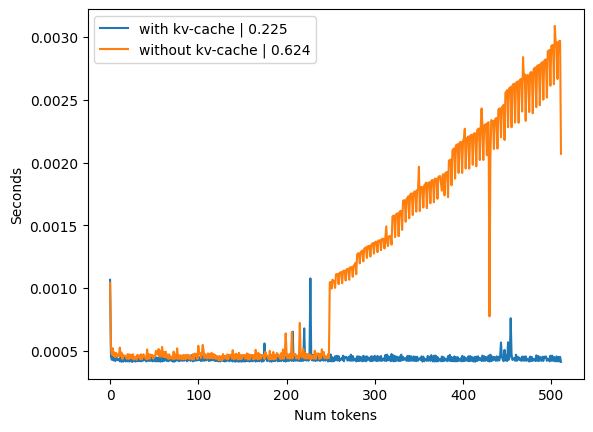

In [32]:
sa = SelfAttention(1024, 8).cuda()

num_tokens = 512
use_kv_cache = True
time_per_step = []


def generate(num_tokens, use_kv_cache):
    time_per_step = []
    current_result = torch.randn(32, num_tokens, 1024).cuda()

    for token_index in trange(num_tokens):
        start_t = time.monotonic()

        with torch.inference_mode():
            if use_kv_cache:
                res = sa(current_result[:, token_index : token_index + 1 ], start_pos=token_index, use_cache=True)
                current_result[:, token_index + 1:token_index + 2] = res
            else:
                res = sa(current_result[:, :token_index + 1], use_cache=False)
                current_result[:, token_index + 1:token_index + 2] = res[:, -1].unsqueeze(dim=1)
                
        ellapsed_t = time.monotonic() - start_t
        time_per_step.append(ellapsed_t)
    return time_per_step

total_time_with_kv_cache = generate(num_tokens, use_kv_cache=True)
total_time_without_kv_cache = generate(num_tokens, use_kv_cache=False)

plt.plot(total_time_with_kv_cache, label=f"with kv-cache | {sum(total_time_with_kv_cache):.3f}")
plt.plot(total_time_without_kv_cache, label=f"without kv-cache | {sum(total_time_without_kv_cache):.3f}")
plt.xlabel("Num tokens")
plt.ylabel("Seconds")
plt.legend()


As we can see starting from which token naive generation slows down a lot. This becomes especially important when we have a large context

# Triton

The aim of the Triton framework, developed by OpenAI, is to simplify and optimize the development of highly efficient GPU-based computations for deep learning models. It provides a Python-like programming environment that allows researchers and developers to write highly parallel and performant custom operations more easily than traditional GPU programming approaches, such as CUDA. Triton aims to make it more accessible for developers to leverage GPU acceleration, ultimately facilitating the development of faster and more efficient deep learning models.

The examples are taken from https://triton-lang.org/main/index.html, so feel free to read the documentation yourself

## Vector Addition

In [4]:
@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector.
    y_ptr,  # *Pointer* to second input vector.
    output_ptr,  # *Pointer* to output vector.

    n_elements,  # Size of the vector.
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
    # NOTE: `constexpr` so it can be used as a shape value.
):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:

    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.

    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    # NOTE
    # tl.device_print('arange', tl.arange(0, BLOCK_SIZE))

    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

In [5]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()

    # The SPMD (single program, multiple data) launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [6]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


## What is a stride in memory formats?

In memory formats, a stride is a term that describes the step size or the distance (measured in elements or bytes) between consecutive elements of a data structure (such as an array or a tensor) along a particular dimension when laid out in memory. Strides are crucial for efficiently accessing multi-dimensional data structures, especially when dealing with operations that require reshaping, slicing, or broadcasting of data without physically rearranging it in memory.

For instance, consider a 2D array (matrix) stored in row-major order (common in C and Python numpy arrays), where all elements of a row are stored in contiguous memory locations. The stride along the row dimension (often called the "row stride") would be 1, indicating that elements along a row are adjacent in memory. The stride along the column dimension (the "column stride"), however, would be equal to the number of columns in the array, as one has to skip all elements of a row to move to the next element in a column.

By manipulating strides, software libraries can implement operations like transposition, slicing, and various tensor manipulations efficiently, allowing for complex data manipulations without the need for expensive memory copies. Strides are a fundamental concept in libraries that handle multi-dimensional data structures, ensuring data is accessed and manipulated efficiently in memory.


![image](https://pytorch.org/assets/images/tensor/image1.png)

In [11]:
import torch.backends.xnnpack

print("XNNPACK is enabled: ", torch.backends.xnnpack.enabled, "\n")

N, C, H, W = 2, 3, 200, 200
x = torch.rand(N, C, H, W)
print("Contiguous shape: ", x.shape)
print("Contiguous stride: ", x.stride())
print()

xcl = x.to(memory_format=torch.channels_last)
print("Channels-Last shape: ", xcl.shape)
print("Channels-Last stride: ", xcl.stride())

XNNPACK is enabled:  True 

Contiguous shape:  torch.Size([2, 3, 200, 200])
Contiguous stride:  (120000, 40000, 200, 1)

Channels-Last shape:  torch.Size([2, 3, 200, 200])
Channels-Last stride:  (120000, 1, 600, 3)


## MatMul

![image](https://triton-lang.org/main/_images/grouped_vs_row_major_ordering.png)

In [12]:

# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)

In [13]:
def matmul(a, b, activation="", verbose=False):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    M, K = a.shape
    K, N = b.shape

    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)

    if verbose:
        print(f"{M=} {K=} {N=}")
        print(f"{a.stride(0)=}, {a.stride(1)=}")
        print(f"{b.stride(0)=}, {b.stride(1)=}")
        print(f"{c.stride(0)=}, {c.stride(1)=}")

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

In [15]:
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = matmul(a, b, activation="leaky_relu")

### Yet another profiler

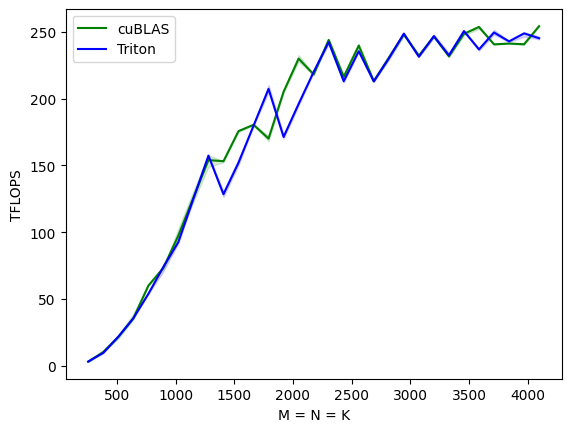

In [16]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=False)

# Flash Attention

Flash Attention is a highly efficient attention mechanism designed to significantly reduce the computational cost and memory usage associated with processing large-scale inputs in Transformer models. It leverages a novel algorithm that allows for the computation of attention weights and the aggregation of context vectors in a single pass, improving both speed and efficiency. This innovation enables the handling of longer sequences in natural language processing tasks and other applications, making Transformers more scalable and practical for a broader range of datasets and computational constraints.

[FlashAttention](https://arxiv.org/pdf/2205.14135.pdf)

[FlassAttention2](https://arxiv.org/abs/2307.08691)

In [18]:
class DummyAttention(nn.Module):

    def forward(self, q, k, v):
        return F.scaled_dot_product_attention(q, k, v)

In [19]:
dummy_attention = DummyAttention()

dtype = torch.float16
# qkv = torch.randn(64, 1024, 3, 8, 128, dtype=dtype, device="cuda") 
# kv = torch.randn(64, 1024, 2, 8, 128, dtype=dtype, device="cuda")
q = torch.randn(64, 1024, 8, 128, dtype=dtype, device="cuda")
k = torch.randn(64, 1024, 8, 128, dtype=dtype, device="cuda")
v = torch.randn(64, 1024, 8, 128, dtype=dtype, device="cuda")

In [21]:
from torch.backends.cuda import sdp_kernel, SDPBackend

backend_map = {
    SDPBackend.MATH: {"enable_math": True, "enable_flash": False, "enable_mem_efficient": False},
    SDPBackend.FLASH_ATTENTION: {"enable_math": False, "enable_flash": True, "enable_mem_efficient": False},
    SDPBackend.EFFICIENT_ATTENTION: {"enable_math": False, "enable_flash": False, "enable_mem_efficient": True}
}

with sdp_kernel(**backend_map[SDPBackend.FLASH_ATTENTION]):
    p = profile_model(dummy_attention, {'q': q, 'k': k, 'v': v}, ProfilerConfig(amp=False))
    print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel         0.44%     111.000us         0.44%     111.000us       6.167us       0.000us         0.00%       0.000us       0.000us            18  
                                  cudaStreamIsCapturing         0.00%       0.000us         0.00%       0.000us       0.000us       0.000us         0.00%       0.000us       0.000us             3  
cudaOccup

STAGE:2024-03-07 17:49:14 1977:1977 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 17:49:14 1977:1977 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 17:49:14 1977:1977 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [22]:
with sdp_kernel(**backend_map[SDPBackend.EFFICIENT_ATTENTION]):
    p = profile_model(dummy_attention, {'q': q, 'k': k, 'v': v}, ProfilerConfig(amp=False))
    print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaStreamIsCapturing         0.01%       3.000us         0.01%       3.000us       1.000us       0.000us         0.00%       0.000us       0.000us             3  
                                   cudaFuncSetAttribute         0.01%       3.000us         0.01%       3.000us       1.000us       0.000us         0.00%       0.000us       0.000us             3  
         

STAGE:2024-03-07 17:49:28 1977:1977 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-07 17:49:28 1977:1977 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-07 17:49:28 1977:1977 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
